In [0]:
pip install noisereduce

In [0]:
import os
import librosa
import numpy as np

# import IPython
import noisereduce as nr
from scipy.io import wavfile
import scipy.signal
import matplotlib.pyplot as plt

###############for windows
# dataset = {"A":"C:\\Users\\15101126\\Documents\\Sound_Analysis\\data\\A_set\\A_","B":"C:\\Users\\15101126\\Documents\\Sound_Analysis\\data\\B_set\\B_"}
dataset = {"A":"data/A_set/A_","B":"data/B_set/B_"}
###############for set A
# sample_types = {"Ar":"Artifact", "Ex":"Extrahls","Mu":"Murmur","No": "Normal","Unl":"Unlabeled"}
#f#############or set B
sample_types = {"Ex":"Extrahls","Mu":"Murmur","No": "Normal","Unl":"Unlabeled","NMu":"Noisy_Murmur","NNo": "Noisy_Normal"}


def decodeFolder(category):
	print("Starting decoding folder "+category+" ...")
	listOfFiles = os.listdir(category)
	arrays_sound = np.empty((0,193))
	for file in listOfFiles:
		filename = os.path.join(category,file)
		features_sound = extract_feature(filename)
		arrays_sound = np.vstack((arrays_sound,features_sound))
	return arrays_sound

def extract_feature(file_name):
	print("Extracting "+file_name+" ...")
	X, sample_rate = librosa.load(file_name)
	fig, ax = plt.subplots(figsize=(20,4))
	ax.plot(X)
	noisy_part = X[-3500:-1]
	reduced_noise = nr.reduce_noise(audio_clip=X, noise_clip=noisy_part, verbose=False)
	fig, ax = plt.subplots(figsize=(20,4))
	ax.plot(reduced_noise)
	plt.show()
	X = reduced_noise

	stft = np.abs(librosa.stft(X))
	mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
	chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
	mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
	contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
	tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sample_rate).T,axis=0)
	# print("mfccs: ",mfccs.shape,"chroma: ",chroma.shape, "mel: ", mel.shape, "contrast: ", contrast.shape, "tonnetz: ", tonnetz.shape)
	return np.hstack((mfccs,chroma,mel,contrast,tonnetz))

#train data
#normal_sounds = decodeFolder("C:\\Users\\15101126\\Documents\\Sound_Analysis\\data\\A_set\\A_Extrahls")
# normal_labels = [0 for items in normal_sounds]
# murmur_sounds = decodeFolder("murmur")
# murmur_labels = [1 for items in murmur_sounds]
# train_sounds = np.concatenate((normal_sounds, murmur_sounds))
# train_labels = np.concatenate((normal_labels, murmur_labels))
#print(normal_sounds.shape)

#*************************Select datasets*******************
set_data = "B"
smpl_typ = "Ex"
#***********************************************************
#*************************funcitons************************
#for all data set
# pth = dataset[set_data]+sample_types[smpl_typ]
# for i in sample_types:
#     extracted = decodeFolder(dataset[set_data]+sample_types[i])
#     print("**************************")
#     print(dataset[set_data]+sample_types[i], " done!! shape: ",extracted.shape)
#     print("**************************")
#     np.savetxt(set_data+"_"+sample_types[i]+".dat", extracted, fmt='%1.4e')

# for one data set
extract_feature('Bunlabelledtest__159_1307018640315_B.wav')
#***********************************************************

In [0]:
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics as ms
import matplotlib.pyplot as plt


# ##############Loading data################
X = np.loadtxt("Data_X.dat")
y = np.loadtxt("Data_y.dat")

# X = np.loadtxt("prepocess_data/A_merged_distinct_X.dat")
# y = np.loadtxt("prepocess_data/A_merged_distinct_y.dat")
#
#X = np.loadtxt("prepocess_data/A_merged_X.dat")
#y = np.loadtxt("prepocess_data/A_merged_y.dat")

# X = np.loadtxt("prepocess_data\\A_merged_X.dat")
# y = np.loadtxt("prepocess_data\\A_merged_y.dat")
############################## data scaling ##############################
# Normalize data ####{over all accuracy will be reduce}
#X = preprocessing.normalize(X, norm='l1')
X = preprocessing.normalize(X, norm='l2') #ektu better hoy

# Split the data into Training and Testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

# Feature scaling,
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.fit_transform(X_test)
#print(X_test)
neuron = 100
accy = []

############################## Cross Validation #############################
classifier =  MLPClassifier(hidden_layer_sizes=(neuron,neuron,neuron),max_iter=200) #lab a run korate hobe
    
scores = cross_val_score(classifier, X, y, cv=10, scoring = 'accuracy')
print("CV score = ",scores.mean())
print(neuron)
#################Fitting Classifier to the training set#################

classifier.fit(X_train,y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)

#print("Y_pred: \n",y_pred)

# Making the confusion matrix 
cm = confusion_matrix(y_test,y_pred)
print(cm)

TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]


TPR = (TP/(TP+FN)) 
print("TPR: {:0.2f}".format(TPR))

TNR = (TN/(TN+FP)) 
print("TNR: {:0.2f}".format(TNR))

PPV = (TP/(TP+FP)) 
print("PPV: {:0.2f}".format(PPV))

NPV = (TN/(TN+FN)) 
print("NPV: {:0.2f}".format(NPV))

ACC = (TP+TN)/(TP+TN+FP+FN)
print("ACC: {:0.2f}".format(ACC))
##################################

#################ROC plotting and AUC#################

# fpr, tpr, thresholds = roc_curve(y_test, svm_lin.predict_proba(X_test))
# auc = auc(fpr, tpr)



y_test_proba = classifier.predict_proba(X_test)
# print(y_test_proba)
# fpr, tpr, threshold = roc_curve(y_test,y_test_proba[:,1])
fpr, tpr, threshold = roc_curve(y_test,y_test_proba[:,1])
roc_auc = auc(fpr, tpr)
# plt.figure()
# plt.plot(fpr,tpr)
# plt.show()

plt.figure(figsize=(6.4,4.8),dpi=100)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example(Neural Network)')
plt.legend(loc="lower right")
plt.savefig("NeuralNet.png")
plt.show()



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
sns.set_context('paper')

algo_names = ['Logistic\nRegression', 'Naive Bayes', 'Decision Tree', "SVM", "Nearest Neighbour", "Artificial\nNeural Network"]
score_wos = [0.72, 0.74, 0.77, 0.68, 0.67, 0.73]

tips = sns.load_dataset('tips')
sns.barplot(x = algo_names, y = score_wos,
            palette = 'Blues', edgecolor = 'w')

plt.

print(tips)
plt.show()

<Figure size 640x480 with 0 Axes>

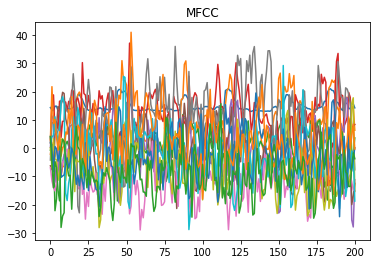

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

(rate,sig) = wav.read("Bunlabelledtest__159_1307018640315_B.wav")
mfcc_feat = mfcc(sig,rate)

plt.figure(figsize=(6.4,4.8),dpi=100)
ig, ax = plt.subplots()
# mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
# cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
# #Showing mfcc_data
# plt.show()
#Showing mfcc_feat
plt.plot(mfcc_feat)
plt.savefig("Noise_reduced_MFCC.png")
plt.show()

this cell is for plotting STFT 

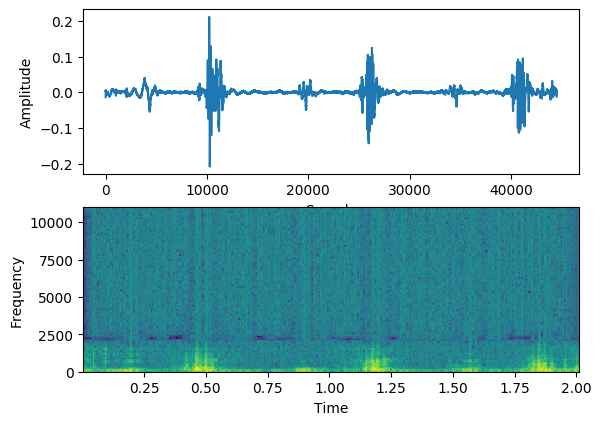

In [0]:
#import the pyplot and wavfile modules 
import noisereduce as nr
import matplotlib.pyplot as plot
import librosa

from scipy.io import wavfile
# Read the wav file (mono)
#samplingFrequency, signalData = wavfile.read('Bunlabelledtest__159_1307018640315_B.wav')
X, sample_rate = librosa.load('Bunlabelledtest__159_1307018640315_B.wav')
noisy_part = X[-3500:-1]
reduced_noise = nr.reduce_noise(audio_clip=X, noise_clip=noisy_part, verbose=False)
# Plot the signal read from wav file
plt.figure(figsize=(6.4,4.8),dpi=100)
plot.subplot(211)
# plot.title('Spectrogram of a wav file with piano music')
plot.plot(reduced_noise)
plot.xlabel('Sample')
plot.ylabel('Amplitude')

plot.subplot(212)
plot.specgram(reduced_noise,Fs=sample_rate)
plot.xlabel('Time')
plot.ylabel('Frequency')
plt.savefig("Noise_reduced_STFT.png")
plot.show()

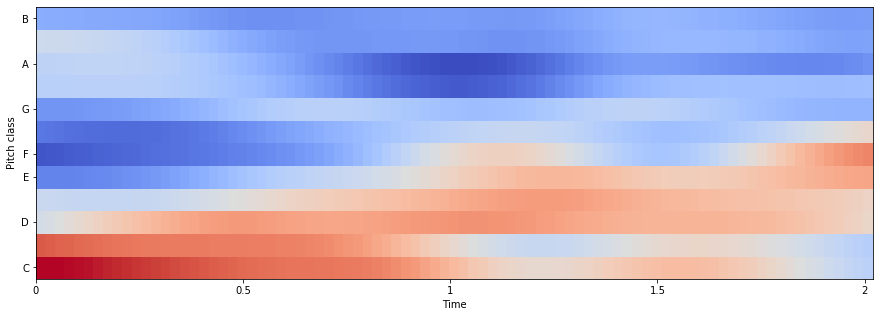

In [0]:
#import the pyplot and wavfile modules 
import noisereduce as nr
import matplotlib.pyplot as plt
import librosa ,librosa.display
from matplotlib import cm
from scipy.io import wavfile
# Read the wav file (mono)
#samplingFrequency, signalData = wavfile.read('Bunlabelledtest__159_1307018640315_B.wav')
X, sample_rate = librosa.load('Bunlabelledtest__159_1307018640315_B.wav')
noisy_part = X[-3500:-1]
reduced_noise = nr.reduce_noise(audio_clip=X, noise_clip=noisy_part, verbose=False)
# Plot the signal read from wav file
# plt.figure(figsize=(6.4,4.8),dpi=100)
# plot.subplot(211)
# # plot.title('Spectrogram of a wav file with piano music')
# plot.plot(X)
# plot.xlabel('Sample')
# plot.ylabel('Amplitude')


chromagram = librosa.feature.chroma_stft(reduced_noise, sr=sample_rate, hop_length=512)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

# plt.plot(mfcc_feat)
# plot.xlabel('Time')
# plot.ylabel('Frequency')
plt.savefig("Noise_reduced_Chroma.png")
# plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# from mpl_toolkits.mplot3d import Axes3D

X = np.loadtxt("Data_X.dat")
y = np.loadtxt("Data_y.dat")

# X = preprocessing.normalize(X, norm='l2')
# sc = StandardScaler()
# X = sc.fit_transform(X)
X = preprocessing.normalize(X, norm='l2')
# print(X.shape)
y_temp_DI = np.array(X[:,221])
#y_temp_DII = np.array(X[:,235])
#y_temp_DIII = np.array(X[:,245])
x_temp = np.array(X[:,225])

#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection='3d')
le = ['Normal', 'Disease']
plt.figure(figsize=(10, 8))
plt.title('Attribute Presentation[Scaled]')
plt.xlabel('P curve Amplitude')
plt.ylabel('R curve Amplitude')
c=0

for i in y:
	if(i==1):
		 plt.plot(x_temp[c],y_temp_DI[c] , 'g+')
		# plt.plot(x_temp[c],y_temp_DII[c] , 'g*')
#		ax.scatter(y_temp_DI, y_temp_DII, y_temp_DIII, c='g', marker='+')
	# elif(i==10):
	else:
		 plt.plot(x_temp[c],y_temp_DI[c] , 'r+')
		# plt.plot(x_temp[c],y_temp[c] , 'r*')
#		ax.scatter(y_temp_DI, y_temp_DII, y_temp_DIII, c='r', marker='^')
	c+=1
plt.plot(x_temp[0],y_temp_DI[0] , 'g+',label=le[0])
plt.plot(x_temp[0],y_temp_DI[0] , 'r+', label=le[1])
plt.legend(loc = 4)
# plt.plot(x_temp,y_temp , 'go')
# plt.axis([20, 100, 1, 12.5])
plt.show()

(193, 193)


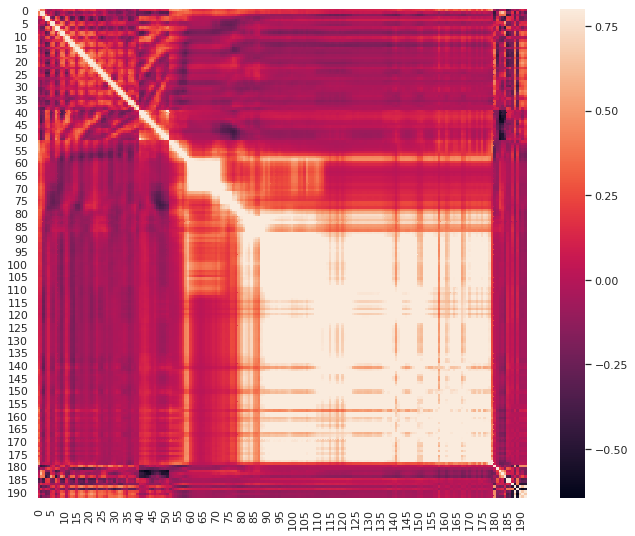

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
import pandas as pd


X = np.loadtxt("Data_X.dat")
y = np.loadtxt("Data_y.dat")
df = pd.DataFrame(data=X)
# col = 57

# x1 = np.array(X[0:50,col])
# x2 = np.array(X[205:255,col])

# y1 = np.array(X[0:50,26])
# ax = sns.scatterplot(x=x1, y=y1)
# ax = sns.scatterplot(x=x2, y=y1)
# plt.show()

#correlation matrix
corrmat = df.corr()
print(corrmat.shape)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.savefig("Heatmap_attribute.png")

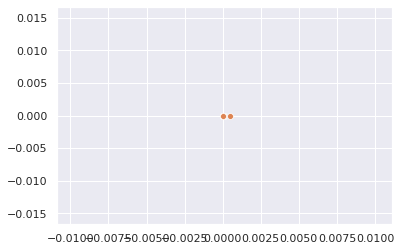

<Figure size 432x288 with 0 Axes>

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
import pandas as pd


X = np.loadtxt("Data_X.dat")
y = np.loadtxt("Data_y.dat")

X = preprocessing.normalize(X, norm='l2')
# df = pd.DataFrame(data=X)
col1 = 135
col2 = 80
col = 80

x1 = np.array(X[0:50,col])
x2 = np.array(X[205:255,col])

y1 = np.array(X[0:50,175])

ax = sns.scatterplot(x=x1, y=y1)
ax = sns.scatterplot(x=x2, y=y1)
plt.show()
plt.savefig("attribute_plot1_180_0.png")

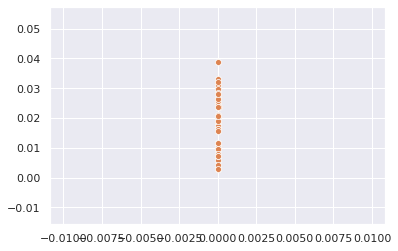

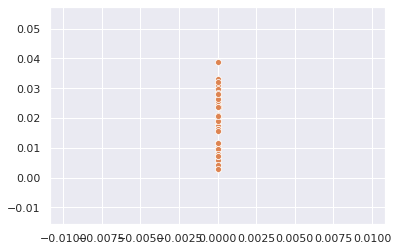

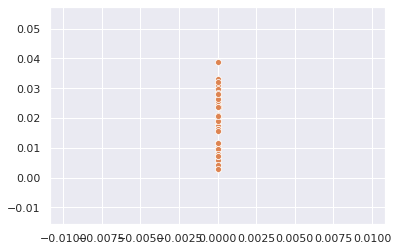

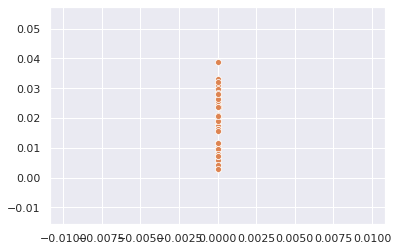

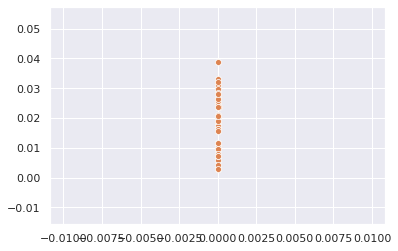

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
import pandas as pd


X = np.loadtxt("Data_X.dat")
y = np.loadtxt("Data_y.dat")

X = preprocessing.normalize(X, norm='l2')
# df = pd.DataFrame(data=X)
col1 = 135
col2 = 80
# col = 80
for col in range(100,105):

  x1 = np.array(X[0:50,col])
  x2 = np.array(X[205:255,col])

  y1 = np.array(X[0:50,10])

  ax = sns.scatterplot(x=x1, y=y1)
  ax = sns.scatterplot(x=x2, y=y1)
  plt.show()


# plt.savefig("attribute_plot1_180_0.png")